# CS 178 Project: Sentiment Analysis on IMDB Movie Reviews

**Authors:** Arun Malani, Brock Allan, Nathan Chau

## Introduction: Exploring the IMDB Review Dataset

We will be working on the IMDB Reviews dataset which is an NLP (Natural Language Processing) dataset. This dataset includes 50,000 reviews with 2 labels, being positive or negative, where each review is a txt file containing 1 movie review. The 50,000 reviews are broken down into 25,000 for training and 25,000 for testing. The same 50,000 reviews are also used as unlabeled data for unsupervised learning. In this 50,000 reviews are 25,000 positive and 25,000 negative reviews where each movie has at most 30 reviews. The training and testing data sets are disjoint, therefore no significant improvements can come from memorization of data. 

The reviews are scored as follows:

    Negative reviews are those with a score <=4 out of 10
    Positive reviews are those with a score >=7 out of 10
    Neutral reviews are those with a score 5-6 out of 10, included only in unlabeled data

First of all we need to load in our data from the local directory with this project:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.feature_extraction.text import CountVectorizer #used to create a bag of words in the NLP
from sklearn.metrics import accuracy_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(1234) # for repeatability

PROJECT_DIR = Path.cwd() #the working directory is where this file is located
DATA_DIR = PROJECT_DIR #data is located in our current directory
TRAIN_DIR = DATA_DIR / "train" #training data, txt files, are located in the "train" folder
TEST_DIR = DATA_DIR / "test" #Testing data, txt files, are located in the "test" folder


After running the above cell the following should be true:

    PROJECT_DIR and DATA_DIR are the directory where all data and this notebook file are located
    TRAIN_DIR is the directory of the training data folder, containing 25,000 txt files
    TEST_DIR is the directory of the testing data folderm containing 25,000 txt files

The next step is to actually load all these txt files into a structure we can use:

In [32]:
def load_reviews(directory, label=None):
    reviews = []
    if not directory.exists():
        return reviews
    for file_path in directory.glob("*.txt"):#looks at all files ending in .txt
        name_without_ext = file_path.stem
        parts = name_without_ext.split('_')
        if len(parts) == 2:
            file_id, rating = parts
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()#reads all of the review from the txt file
            reviews.append((text, label, int(file_id), int(rating)))#adds the review, its label, id, and rating to a list
    return reviews

def load_dataset():
    train_pos = load_reviews(TRAIN_DIR / "pos", label="pos") #loads all positive reviews into a list
    train_neg = load_reviews(TRAIN_DIR / "neg", label="neg") #loads all negative reviews into a list
    train_data = train_pos + train_neg #combines the two lists into train_data
    
    test_pos = load_reviews(TEST_DIR / "pos", label="pos") #loads all positive test reviews into a list
    test_neg = load_reviews(TEST_DIR / "neg", label="neg") #loads all negative test reviews into a list
    test_data = test_pos + test_neg #combines the two test lists

    unlabel_data = load_reviews(TRAIN_DIR / "unsup")
    return train_data, test_data, unlabel_data

train_data, test_data, unlabel_data = load_dataset() # train_data, test_data, unlabel_data are lists of their respective data


The above code reads all txt files, aka reviews, into a few lists. Train_pos and train_neg for the postive and negative reviews from training data. Test_pos and test_neg for the positive and negative reviews from testing data. These 4 lists are combined to form the following:

    train_data = train_pos + train_neg ... = total training data, 25,000 data points
    test_data = test_pos + test_neg ... = total testing data, 25,000 data points

We organized these two lists where each index is a tuple, including:

    index 0: the movie reviews text
    index 1: label (pos/neg)
    index 2: txt file ID
    index 3: rating of the movie (scale 1-10)

So for example, to access the first move review and its associated tuple fields one would do train_data[0][0] to access the text of the review
    

In [34]:
print(f'Review: {(train_data[0][0]):.75}...\nType of Review: {train_data[0][1]}\nReview ID: {train_data[0][2]}\nRating: {train_data[0][3]}')
print()
print(f'Review: {(test_data[0][0]):.75}...\nType of Review: {test_data[0][1]}\nReview ID: {test_data[0][2]}\nRating: {test_data[0][3]}')
print()
print(f'Review: {(unlabel_data[0][0]):.75}...\nType of Review: {unlabel_data[0][1]}\nReview ID: {unlabel_data[0][2]}\nRating: {unlabel_data[0][3]}')

Review: Bromwell High is a cartoon comedy. It ran at the same time as some other pr...
Type of Review: pos
Review ID: 0
Rating: 9

Review: I went and saw this movie last night after being coaxed to by a few friends...
Type of Review: pos
Review ID: 0
Rating: 10

Review: I admit, the great majority of films released before say 1933 are just not ...
Type of Review: None
Review ID: 0
Rating: 0


A list of tuples isnt ideal for data exploration in Machine learning models, we decided to turn this structure into a dataFrame or table for easy access:

In [36]:
train_df = pd.DataFrame(train_data, columns=['text', 'label', 'file_id', 'rating'])
test_df = pd.DataFrame(test_data, columns=['text', 'label', 'file_id', 'rating'])
unlabel_df = pd.DataFrame(unlabel_data, columns=['text', 'label', 'file_id', 'rating'])

print("Train Data:")
print(train_df.head())
print()
print("Test Data:")
print(test_df.head())
print()
print("Unlabeled Data:")
print(unlabel_df.head())

Train Data:
                                                text label  file_id  rating
0  Bromwell High is a cartoon comedy. It ran at t...   pos        0       9
1  Homelessness (or Houselessness as George Carli...   pos    10000       8
2  Brilliant over-acting by Lesley Ann Warren. Be...   pos    10001      10
3  This is easily the most underrated film inn th...   pos    10002       7
4  This is not the typical Mel Brooks film. It wa...   pos    10003       8

Test Data:
                                                text label  file_id  rating
0  I went and saw this movie last night after bei...   pos        0      10
1  Actor turned director Bill Paxton follows up h...   pos    10000       7
2  As a recreational golfer with some knowledge o...   pos    10001       9
3  I saw this film in a sneak preview, and it is ...   pos    10002       8
4  Bill Paxton has taken the true story of the 19...   pos    10003       8

Unlabeled Data:
                                               

There are a few things we can do with this type of data, first of all its an NLP dataset with a decision on whether or not some review constitutes a positive or negative review. We are also provided with an unlabeled data set that is perfect for unsupervised learning. Before applying a learning model lets first take a look at the raw data. We will describe "Sentiment" as the following:

    Positive – expresses a favorable opinion or emotion.
    Example: “I loved this movie! It was fantastic.”

    Negative – expresses an unfavorable opinion or emotion.
    Example: “This movie was terrible. I hated it.”

    Neutral – expresses factual or unemotional statements.
    Example: “The movie was released in 2020.”

To see the trend of Sentiment in the raw data we can display it in a couple graphs, Review Length vs Sentiment and most frequent words per review.

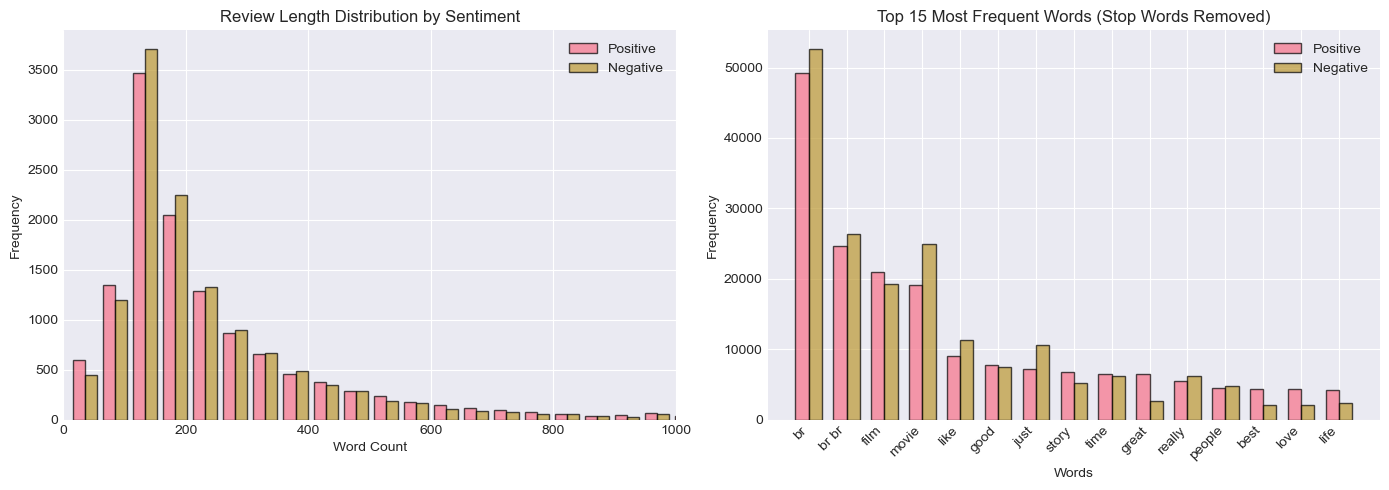

In [26]:
train_df['word_count'] = train_df['text'].str.split().str.len() #splits each review into words, counts them, and stores it as a word count

vectorizer_no_stop = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'#removes common stop words
) #creates a "bag of words" by converting text into a numeric feature matrix

X_train_vec_no_stop = vectorizer_no_stop.fit_transform(train_df['text'].values) #a vectorizer learns vocabulary
feature_names_no_stop = vectorizer_no_stop.get_feature_names_out() #contains the words corresponing to each column

pos_texts = train_df[train_df['label']=='pos']['text'].values
neg_texts = train_df[train_df['label']=='neg']['text'].values

X_pos = vectorizer_no_stop.transform(pos_texts)
X_neg = vectorizer_no_stop.transform(neg_texts) #turns positive and negative reviews into matrices

pos_freq = np.array(X_pos.sum(axis=0)).flatten()
neg_freq = np.array(X_neg.sum(axis=0)).flatten()#calculates word frequencies

top_15_idx = np.argsort(pos_freq)[-15:][::-1]
words = [feature_names_no_stop[i] for i in top_15_idx]
pos_freq_top = [pos_freq[i] for i in top_15_idx]
neg_freq_top = [neg_freq[i] for i in top_15_idx] #finds the top 15 most frequent words

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pos_lengths = train_df[train_df['label']=='pos']['word_count']
neg_lengths = train_df[train_df['label']=='neg']['word_count']
axes[0].hist([pos_lengths, neg_lengths], bins=50, label=['Positive', 'Negative'], alpha=0.7, edgecolor='black')
axes[0].set_title('Review Length Distribution by Sentiment')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 1000)
axes[0].legend() #plots review length distribution and top words

x = np.arange(len(words))
width = 0.35
axes[1].bar(x - width/2, pos_freq_top, width, label='Positive', alpha=0.7, edgecolor='black')
axes[1].bar(x + width/2, neg_freq_top, width, label='Negative', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 15 Most Frequent Words (Stop Words Removed)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(words, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()


The left graph titled "Review Length Distribution by Sentiment" plots Word Count vs Frequency. This graph shows that most reviews fall within a word count of between 50 - 300 words. In this subset, negative reviews tend to appear more then positive reviews. This graph also shows us that as the word count increases, the review is more likely to be negative than positive where positive reviews are more likely in smaller word count reviews. 

The right graph titled "Top 15 Most Frequent Words" plots Words vs Frequency. This graph shows that out of all reviews, what words ocurred the most. The first two words br and br br are actually line breaks in the review and showcases that since they are the most frequent, most reviews have paragraph form. One could also assume that longer reviews would increase this number of line breaks and contain a larger word count. This graph shows that negative reviews were more likely to contain line breaks and therefore more text. The graph also showcases common movie words or sentiment such as movie or good.

This initial evaluation of the data proposes the following set of questions:

    Is there a correlation between word count and review type?
    Are reviews with a large number of line breaks more likely to be a certain label?
    Are there frequent words that can evaluate to a certain label?
    Can we classify a movie review as positive or negative given the above data?

We are primarily concerned with the last question, classifying a movie review as positive or negative given unseen data. In this project we will apply a few models to achieve this goal. Given that we are provided with unlabeled data, we will start with an unsupervised model to explore how the data is clustered.

## Model 1: K-Means Sentiment
The following is similar to what we did above, instead we used the unlabeled data from the dataset to train a K-means clustering model.


In [47]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

X_train_text = unlabel_df['text'].values   # unlabeled data
X_test_text  = test_df['text'].values      # labeled test set

y_test = test_df['label'].values
y_test_binary = (y_test == 'pos').astype(int)

vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec  = vectorizer.transform(X_test_text)

kmeans = KMeans(
    n_clusters=3,# 3 clusters, postive, neutral, and negative
    init='k-means++',
    n_init=1,
    random_state=1234
)

kmeans.fit(X_train_vec)
svd = TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_train_vec)
centroids_2d = svd.transform(kmeans.cluster_centers_)

The following code plots our clusters in such a way that we can label each cluster based on a type of review.

    Negative reviews are clustered as red
    Positive reviews are clustered as green
    Neutral reviews are clustered as gray

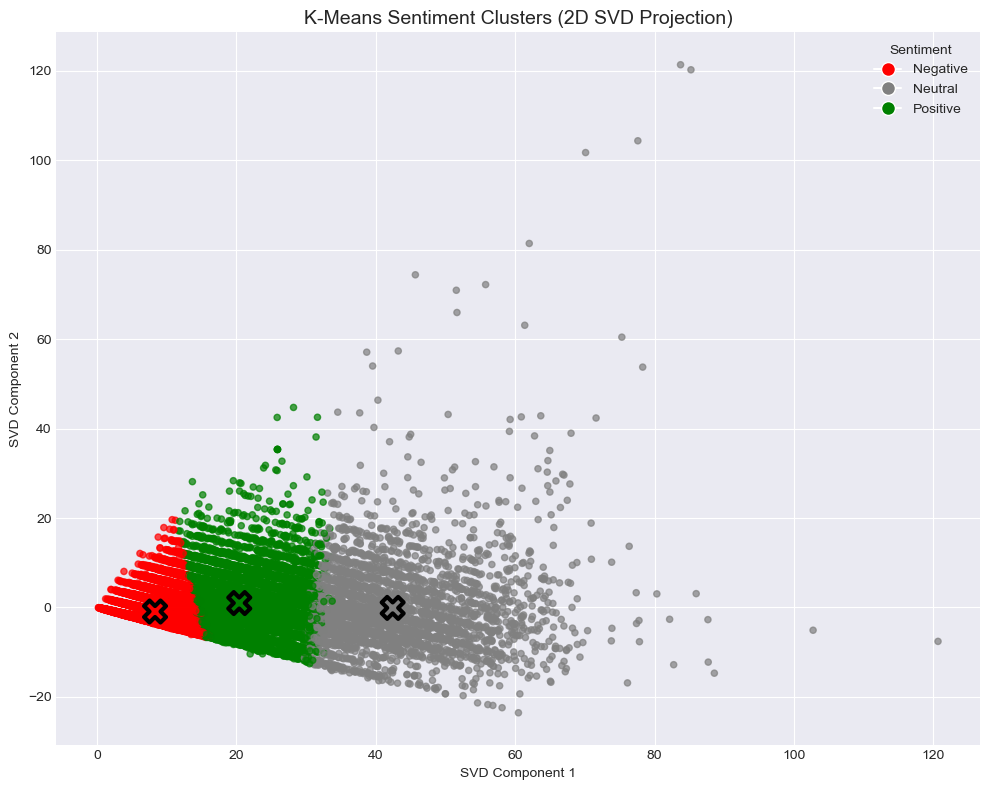

Negative: 33909 points
Neutral: 3334 points
Positive: 12757 points


In [76]:
sentiment_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}
sentiment_colors = {
    "negative": "red",
    "neutral": "gray",
    "positive": "green"
}
point_colors = [
    sentiment_colors[sentiment_map[label]]
    for label in kmeans.labels_
] #maps clusters to their sentiment and color

centroid_colors = [
    sentiment_colors[sentiment_map[cid]]
    for cid in range(kmeans.n_clusters)
]

plt.figure(figsize=(10, 8))

plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=point_colors,
    s=20,
    alpha=0.7
)

plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c=centroid_colors,
    marker='X',
    s=250,
    linewidths=3,
    edgecolor="black"
)

plt.title("K-Means Sentiment Clusters (2D SVD Projection)", fontsize=14)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=sentiment_colors["negative"],
               markersize=10, label="Negative"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=sentiment_colors["neutral"],
               markersize=10, label="Neutral"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=sentiment_colors["positive"],
               markersize=10, label="Positive")
]

plt.legend(handles=legend_handles, title="Sentiment")
plt.tight_layout()
plt.show()

labels = kmeans.labels_

unique, counts = np.unique(labels, return_counts=True)
cluster_names = {0: "Negative", 1: "Neutral", 2: "Positive"}

for cluster_id, count in zip(unique, counts):
    print(f"{cluster_names[cluster_id]}: {count} points")

## Analyzing our K-Means Sentiment model

First of all, lets analyze what we did in the above code. We used a Truncated SVD which is a dimensionality reduction technique used to turn our bag of words into meaningful features. Then we fit a vectorizer on the data to convert it into a vocab or n-grams that encodes how ofter or strongly each word appears. We then trained a Random + distance (k-means++) initialized K-Means clustering model on this data with 3 clusters: positive, neutral, negative, and plotted the above graph. We then outputted how many points were clustered as a specific class.

One major characteristic of our graph details the density of negative and positive clusters, with each cluster containing 10,000+ datapoints. However, we see that our neutral cluster compared to the negative and positive labeled clusters is significantly more varied. This plays into the narrative that negative and positive labels have relatively small ranges of SVD Component 1, but values of greater than approximately 30 will almost always result in categorization of a neutral label.

Another detail that should be noted is that SVD Component 2 does not play a major role in the clustering of our data. As we see in our graph, the data follows the shape of a horizontal line (for the most part) and does not cluster based on SVD Component 2. 

Now there's an underlying question that we have to address before moving forward:

    What does SVD Component 1 and SVD Component 2 mean?

We cannot say for sure exactly what the SVD Components actually quantify, but based on the data we can infer what our SVD Components are identifying. SVD Component 1 most likely represents the polarity, in other words, the distinction between positive words and negative words. If we look at SVD Component 1 as the "sentiment" of each datapoint, it helps us understand how the clustering was formed. SVD Component 2, however, is a bit more tricky but could mean a variety of patterns found in language. It could mean style, length, etc. Since this component doesn't play much of a role into our clustering, we may not have to interpret it as much.



# Other Unsupervised Models

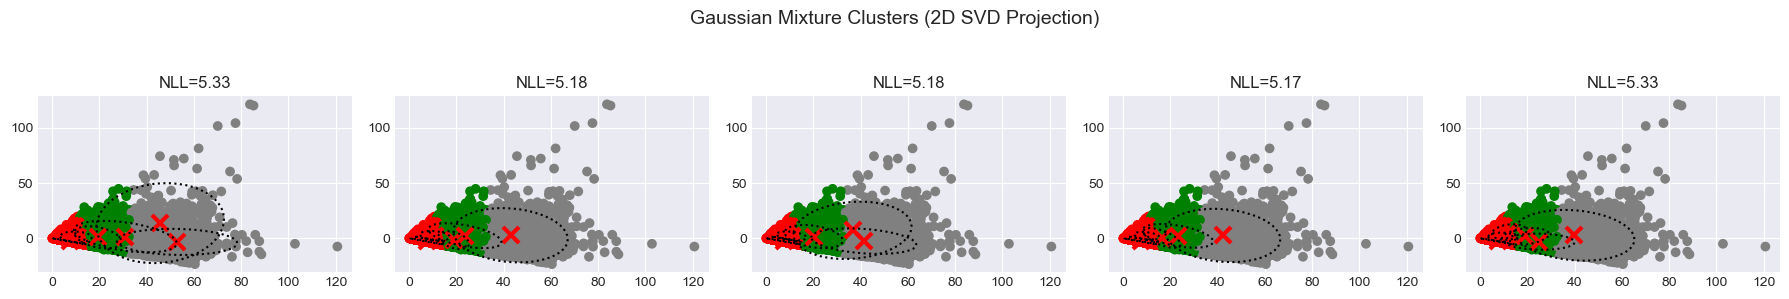

In [74]:
from sklearn.mixture import GaussianMixture

from scipy.linalg import sqrtm
th = np.linspace(-np.pi,np.pi,50); th = np.vstack((np.cos(th),np.sin(th))).T

fig, axes = plt.subplots(1,5, figsize=(18,3))

fig.suptitle("Gaussian Mixture Clusters (2D SVD Projection)", fontsize=14)

for i in range(5):
    clust = GaussianMixture(n_components=6, init_params='k-means++', random_state=1234+i)
    clust.fit(X_2d)
    axes[i].scatter(X_2d[:,0], X_2d[:,1], c=point_colors)
    axes[i].plot(clust.means_[:,0],clust.means_[:,1],'rx',ms=12,mew=3)
    for c in range(len(clust.means_)):
        circle = 2*th @ sqrtm(clust.covariances_[c,:,:]) + clust.means_[c:c+1,:]
        axes[i].plot(circle[:,0],circle[:,1],'k:')        
    axes[i].set_title(f'NLL={-np.round(clust.score(X_2d),2)}')

fig.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

### Gaussian Mixture Analysis

With Gaussian Mixture, datapoints are not assigned to a singular cluster based on nearest datapoints. Instead, we perform a soft-clustering by assigning the probability of each label for each datapoint. Since each datapoint is not hard-assigned a singular cluster, we can see our centroid centers (more accurately our gaussian centers) do not merely represent our 3 labels. As we see in different possible seeds, the gaussian centers are quite varied but usually fall between the borders of each cluster.

Since we have quite a few gaussian centers within the borders of the clusters, we can infer that our data can have sentiments that are vague and may not give us an exact conclusion as to whether their review was positive, negative, or neutral. 

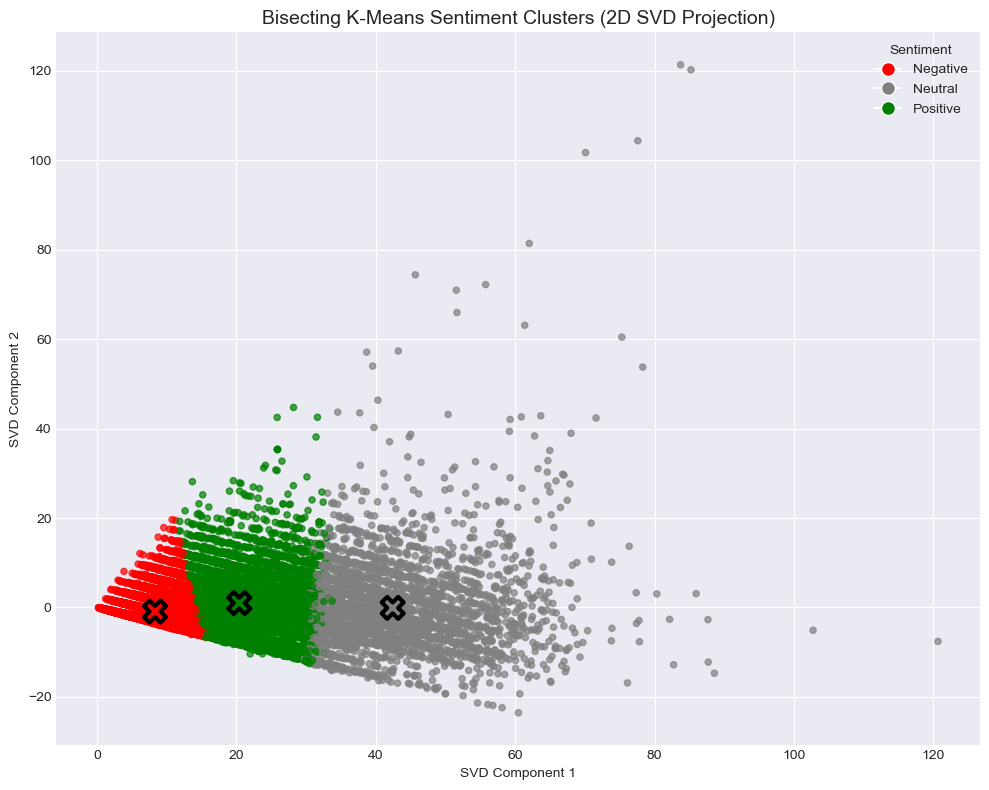

In [78]:
from sklearn.cluster import BisectingKMeans

bkmeans = BisectingKMeans(
    n_clusters=3,
    init='k-means++',
    n_init=1,
    random_state=1234
)

bkmeans.fit(X_train_vec)

centroid_colors = [
    sentiment_colors[sentiment_map[cid]]
    for cid in range(bkmeans.n_clusters)
]

plt.figure(figsize=(10, 8))

plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=point_colors,
    s=20,
    alpha=0.7
)

plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c=centroid_colors,
    marker='X',
    s=250,
    linewidths=3,
    edgecolor="black"
)

plt.title("Bisecting K-Means Sentiment Clusters (2D SVD Projection)", fontsize=14)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=sentiment_colors["negative"],
               markersize=10, label="Negative"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=sentiment_colors["neutral"],
               markersize=10, label="Neutral"),
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=sentiment_colors["positive"],
               markersize=10, label="Positive")
]
plt.legend(handles=legend_handles, title="Sentiment")
plt.tight_layout()
plt.show()


### Bisecting K-Means Anaylsis

Although not immediately different, Bisecting K-Means Clustering functions differently from traditional K-Means with determination of its centroids. While K-Means creates all centroids from the start, Bisecting K-Means instead creates centroids based on previous clusters. However, we can see in this example that Bisecting K-Means does not play a major impact in differentiating itself with normal K-Means. As a result, we cannot infer any additional information about our data.

#### 3.2 Random Forest Baseline


In [ ]:
X_train_text = train_df['text'].values
y_train = train_df['label'].values
X_test_text = test_df['text'].values
y_test = test_df['label'].values

y_train_binary = (y_train == 'pos').astype(int)
y_test_binary = (y_test == 'pos').astype(int)

vectorizer = CountVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words=None
)

X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)
feature_names = vectorizer.get_feature_names_out()

X_train_vec_no_stop = vectorizer_no_stop.transform(X_train_text)
X_test_vec_no_stop = vectorizer_no_stop.transform(X_test_text)

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=1234,
    n_jobs=-1,
    verbose=0
)

rf_baseline.fit(X_train_vec, y_train_binary)

y_train_pred = rf_baseline.predict(X_train_vec)
y_test_pred = rf_baseline.predict(X_test_vec)

train_accuracy = accuracy_score(y_train_binary, y_train_pred)
test_accuracy = accuracy_score(y_test_binary, y_test_pred)

print(f"train accuracy: {train_accuracy:.4f}, test accuracy: {test_accuracy:.4f}")


train accuracy: 1.0000, test accuracy: 0.8476


#### 3.3 Manual Hyperparameter Exploration


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
train_idx, val_idx = next(sss.split(X_train_vec, y_train_binary))

X_train_subset = X_train_vec[train_idx]
y_train_subset = y_train_binary[train_idx]
X_val_subset = X_train_vec[val_idx]
y_val_subset = y_train_binary[val_idx]


#### 3.4 Exploring max_depth


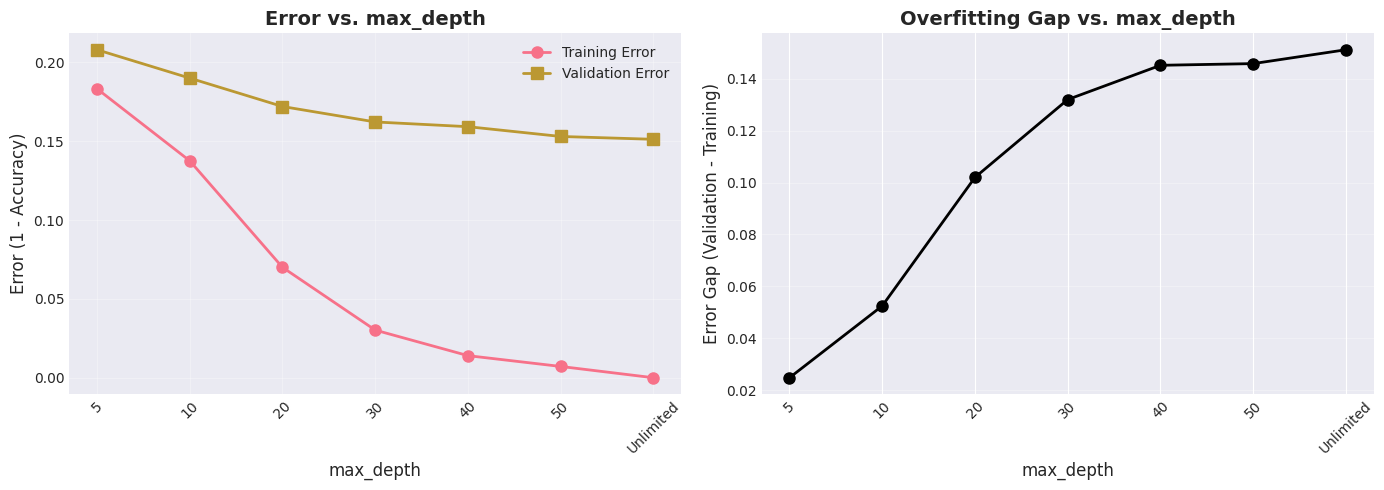

best max_depth: None


In [10]:
max_depths = [5, 10, 20, 30, 40, 50, None]
depth_results = {'depth': [], 'train_err': [], 'val_err': [], 'gap': []}

for depth in max_depths:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=depth,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    depth_results['depth'].append(depth if depth else 'Unlimited')
    depth_results['train_err'].append(train_err)
    depth_results['val_err'].append(val_err)
    depth_results['gap'].append(gap)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

depths_str = [str(d) for d in depth_results['depth']]
x_pos = range(len(depths_str))

axes[0].plot(x_pos, depth_results['train_err'], 'o-', label='Training Error', linewidth=2, markersize=8)
axes[0].plot(x_pos, depth_results['val_err'], 's-', label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(depths_str, rotation=45)
axes[0].set_xlabel('max_depth', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title('Error vs. max_depth', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(x_pos, depth_results['gap'], 'o-', color='black', linewidth=2, markersize=8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(depths_str, rotation=45)
axes[1].set_xlabel('max_depth', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. max_depth', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

best_depth_idx = np.argmin(depth_results['val_err'])
best_depth = max_depths[best_depth_idx]

print(f"best max_depth: {best_depth}")

#### 3.5 Exploring n_estimators


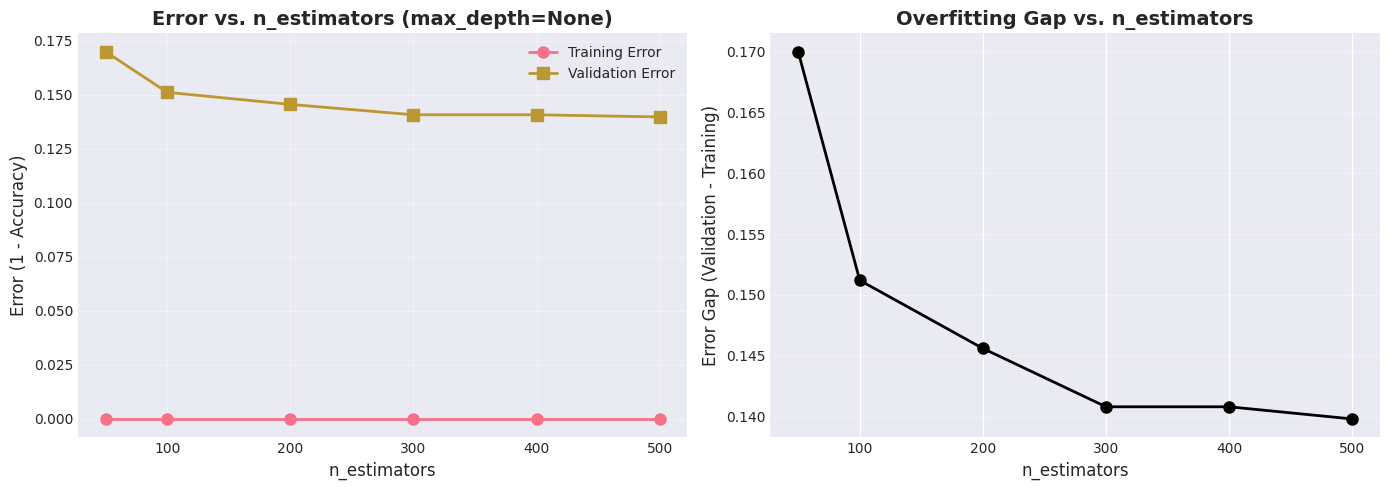

best # of trees: 500


In [11]:
n_estimators_range = [50, 100, 200, 300, 400, 500]
estimator_results = {'n_est': [], 'train_err': [], 'val_err': [], 'gap': []}

for n_est in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=best_depth,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    estimator_results['n_est'].append(n_est)
    estimator_results['train_err'].append(train_err)
    estimator_results['val_err'].append(val_err)
    estimator_results['gap'].append(gap)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(estimator_results['n_est'], estimator_results['train_err'], 'o-', 
             label='Training Error', linewidth=2, markersize=8)
axes[0].plot(estimator_results['n_est'], estimator_results['val_err'], 's-', 
             label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xlabel('n_estimators', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title(f'Error vs. n_estimators (max_depth={best_depth})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(estimator_results['n_est'], estimator_results['gap'], 'o-', 
             color='black', linewidth=2, markersize=8)
axes[1].set_xlabel('n_estimators', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. n_estimators', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

best_n_est_idx = np.argmin(estimator_results['val_err'])
best_n_est = estimator_results['n_est'][best_n_est_idx]

print(f"best # of trees: {best_n_est}")


#### 3.6 Exploring min_samples_split


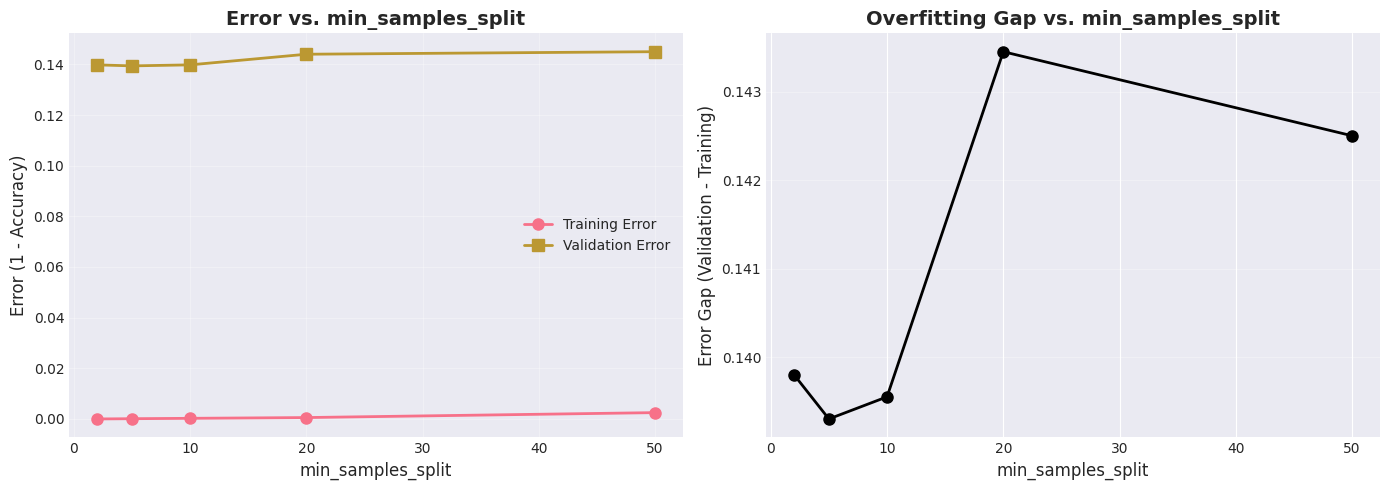

best min_samples_split: 5


In [12]:
min_samples_splits = [2, 5, 10, 20, 50]
split_results = []

for min_split in min_samples_splits:
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_split=min_split,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    split_results.append({
        'value': min_split,
        'train_err': train_err,
        'val_err': val_err,
        'gap': gap
    })

best_split = min(split_results, key=lambda x: x['val_err'])
best_min_split = best_split['value']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

split_vals = [r['value'] for r in split_results]
axes[0].plot(split_vals, [r['train_err'] for r in split_results], 'o-', label='Training Error', linewidth=2, markersize=8)
axes[0].plot(split_vals, [r['val_err'] for r in split_results], 's-', label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xlabel('min_samples_split', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title('Error vs. min_samples_split', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(split_vals, [r['gap'] for r in split_results], 'o-', color='black', linewidth=2, markersize=8)
axes[1].set_xlabel('min_samples_split', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. min_samples_split', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"best min_samples_split: {best_min_split}")


#### 3.7 Exploring min_samples_leaf


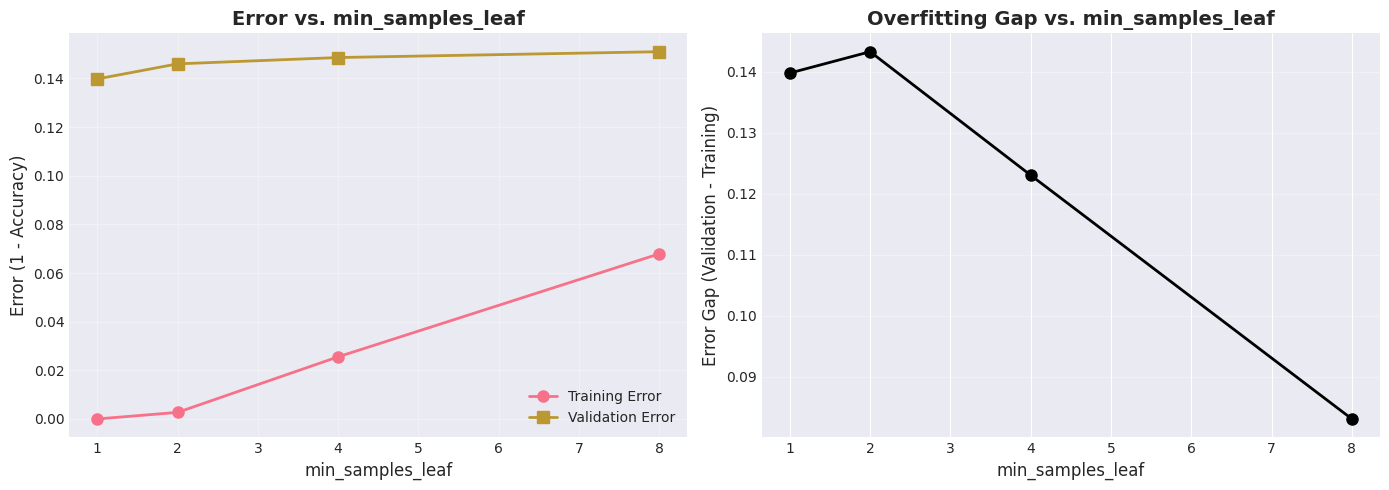

best min_samples_leaf: 1


In [13]:
min_samples_leaves = [1, 2, 4, 8]
leaf_results = []

for min_leaf in min_samples_leaves:
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_leaf=min_leaf,
        random_state=1234,
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train_subset, y_train_subset)
    train_acc = rf.score(X_train_subset, y_train_subset)
    val_acc = rf.score(X_val_subset, y_val_subset)
    train_err = 1 - train_acc
    val_err = 1 - val_acc
    gap = val_err - train_err
    leaf_results.append({
        'value': min_leaf,
        'train_err': train_err,
        'val_err': val_err,
        'gap': gap
    })

best_leaf = min(leaf_results, key=lambda x: x['val_err'])
best_min_leaf = best_leaf['value']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

leaf_vals = [r['value'] for r in leaf_results]
axes[0].plot(leaf_vals, [r['train_err'] for r in leaf_results], 'o-', label='Training Error', linewidth=2, markersize=8)
axes[0].plot(leaf_vals, [r['val_err'] for r in leaf_results], 's-', label='Validation Error', linewidth=2, markersize=8)
axes[0].set_xlabel('min_samples_leaf', fontsize=12)
axes[0].set_ylabel('Error (1 - Accuracy)', fontsize=12)
axes[0].set_title('Error vs. min_samples_leaf', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(leaf_vals, [r['gap'] for r in leaf_results], 'o-', color='black', linewidth=2, markersize=8)
axes[1].set_xlabel('min_samples_leaf', fontsize=12)
axes[1].set_ylabel('Error Gap (Validation - Training)', fontsize=12)
axes[1].set_title('Overfitting Gap vs. min_samples_leaf', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"best min_samples_leaf: {best_min_leaf}")

#### 3.8 Final Optimized Model


In [14]:

final_params = {
    'n_estimators': best_n_est,
    'max_depth': best_depth,
    'min_samples_split': best_min_split,
    'min_samples_leaf': best_min_leaf,
    'max_features': 'sqrt',
    'random_state': 1234,
    'n_jobs': -1
}

rf_optimized = RandomForestClassifier(**final_params)
rf_optimized.fit(X_train_vec, y_train_binary)

y_train_pred_opt = rf_optimized.predict(X_train_vec)
y_test_pred_opt = rf_optimized.predict(X_test_vec)

train_accuracy_opt = accuracy_score(y_train_binary, y_train_pred_opt)
test_accuracy_opt = accuracy_score(y_test_binary, y_test_pred_opt)

print(f"Final Model Parameters:")
print(f"n_estimators: {best_n_est}")
print(f"max_depth: {best_depth}")
print(f"min_samples_split: {best_min_split}")
print(f"min_samples_leaf: {best_min_leaf}")
print(f"max_features: sqrt")

print()

print(f"Final Model Performance:")
print(f"Training Accuracy: {train_accuracy_opt:.4f}")
print(f"Test Accuracy: {test_accuracy_opt:.4f}")


Final Model Parameters:
n_estimators: 500
max_depth: None
min_samples_split: 5
min_samples_leaf: 1
max_features: sqrt

Final Model Performance:
Training Accuracy: 0.9998
Test Accuracy: 0.8596


#### 3.9 Feature Importance


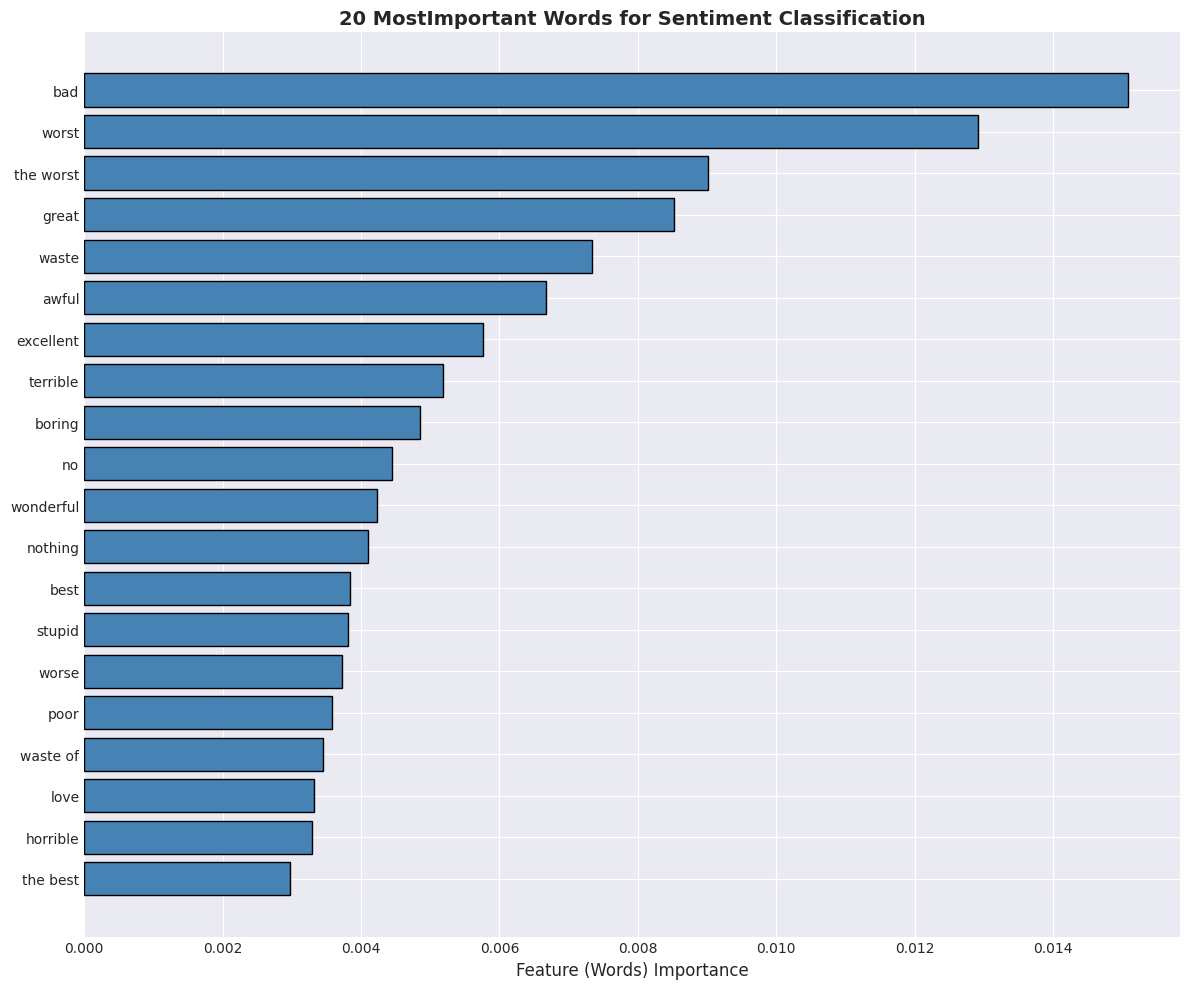

In [15]:
feature_importance = rf_optimized.feature_importances_
top_indices = np.argsort(feature_importance)[-30:][::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]

fig, ax = plt.subplots(figsize=(12, 10))
top_20_features = [f[0] for f in top_features[:20]]
top_20_importance = [f[1] for f in top_features[:20]]

ax.barh(range(len(top_20_features)), top_20_importance, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_20_features)))
ax.set_yticklabels(top_20_features)
ax.set_xlabel('Feature (Words) Importance', fontsize=12)
ax.set_title('20 MostImportant Words for Sentiment Classification', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()



#### 3.10 Confusion Matrix


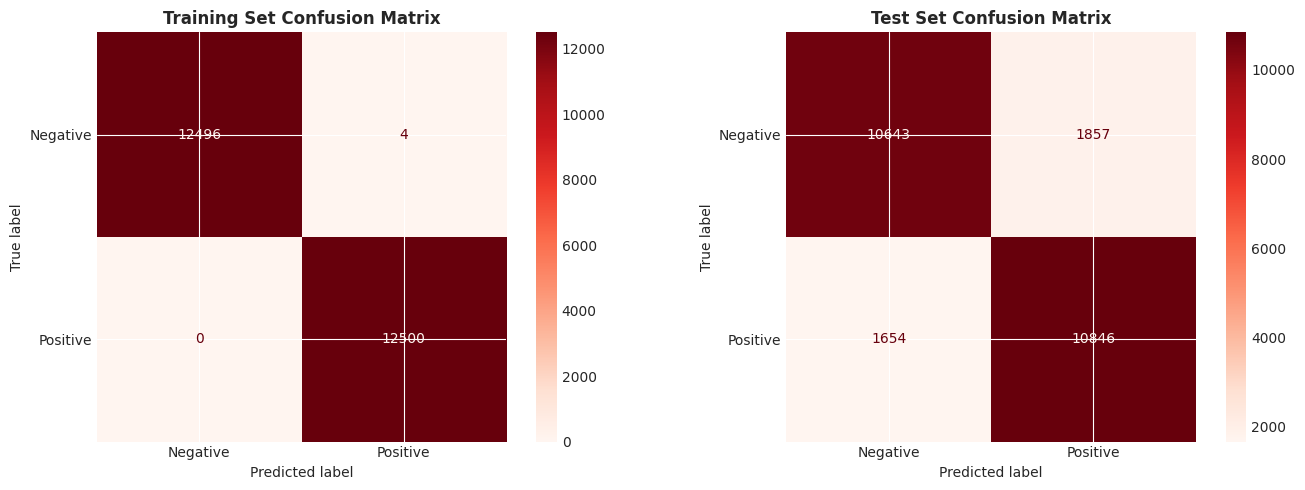

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay.from_predictions(
    y_train_binary, y_train_pred_opt,
    display_labels=['Negative', 'Positive'],
    ax=axes[0],
    cmap='Reds',
    values_format='d'
)
axes[0].set_title('Training Set Confusion Matrix', fontsize=12, fontweight='bold')

ConfusionMatrixDisplay.from_predictions(
    y_test_binary, y_test_pred_opt,
    display_labels=['Negative', 'Positive'],
    ax=axes[1],
    cmap='Reds',
    values_format='d'
)
axes[1].set_title('Test Set Confusion Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



## 4. Additional Depth

### 4.1 Random Forest with GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=1234, n_jobs=-1, verbose=0),
    param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

rf_grid.fit(X_train_subset, y_train_subset)

rf_grid_optimized = rf_grid.best_estimator_
rf_grid_optimized.fit(X_train_vec, y_train_binary)
y_test_pred_grid = rf_grid_optimized.predict(X_test_vec)
test_accuracy_grid = accuracy_score(y_test_binary, y_test_pred_grid)

print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Optimized Model Accuracy: {test_accuracy_grid:.4f}")


### 4.2 Gradient Boosting Baseline


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_baseline = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=1234,
    verbose=0
)

gb_baseline.fit(X_train_subset, y_train_subset)

y_test_pred_gb = gb_baseline.predict(X_test_vec)
test_accuracy_gb = accuracy_score(y_test_binary, y_test_pred_gb)

print(f"Gradient Boosting Baseline: {test_accuracy_gb:.4f}")


Gradient Boosting Baseline: 0.8215


### 4.3 Gradient Boosting with GridSearchCV


In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=1234, verbose=0),
    param_grid_gb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

gb_grid.fit(X_train_subset, y_train_subset)

gb_optimized = gb_grid.best_estimator_
gb_optimized.fit(X_train_vec, y_train_binary)
y_test_pred_gb_opt = gb_optimized.predict(X_test_vec)
test_accuracy_gb_opt = accuracy_score(y_test_binary, y_test_pred_gb_opt)

print(f"Best Parameters: {gb_grid.best_params_}")
print(f"Optimized Model Accuracy: {test_accuracy_gb_opt:.4f}")


Best Parameters: {'learning_rate': 0.15, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Model Accuracy: 0.8555


### 4.4 Model Comparison


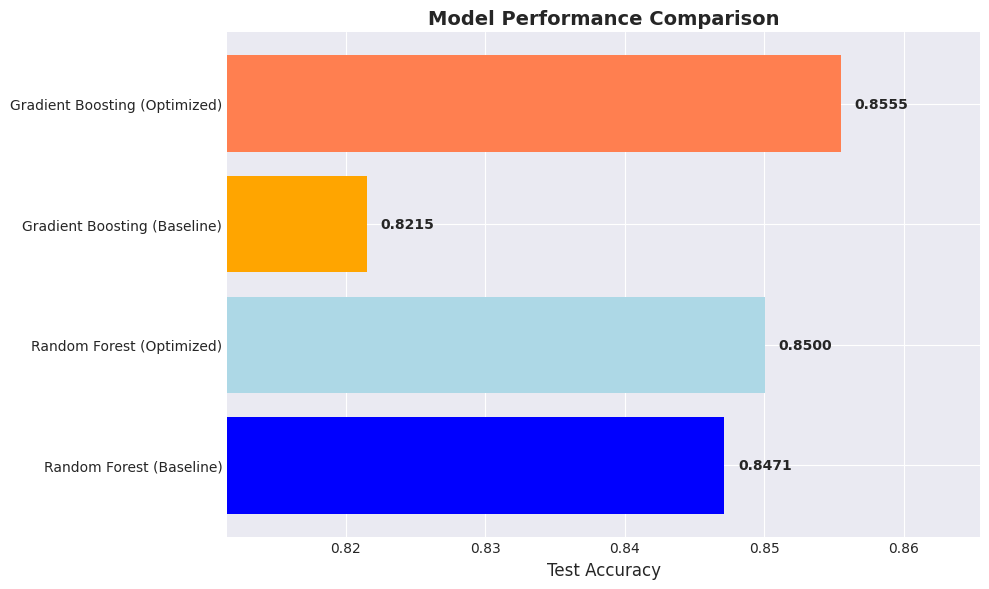

In [ ]:
models_comparison = {
    'Random Forest (Baseline)': test_accuracy,
    'Random Forest (Optimized)': test_accuracy_opt,
    'Gradient Boosting (Baseline)': test_accuracy_gb,
    'Gradient Boosting (Optimized)': test_accuracy_gb_opt
}

fig, ax = plt.subplots(figsize=(10, 6))
models = list(models_comparison.keys())
accuracies = list(models_comparison.values())
colors = ['blue', 'lightblue', 'orange', 'coral']

bars = ax.barh(models, accuracies, color=colors)
ax.set_xlabel('Test Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([min(accuracies) - 0.01, max(accuracies) + 0.01])

for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 0.001, i, f'{acc:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


---

## 5. Validation, Adaptation, and Fine-tuning

### 5.1 Cross-Validation and Performance Assessment

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

gb_cv_scores = cross_val_score(gb_optimized, X_train_vec, y_train_binary, cv=cv, scoring='accuracy', n_jobs=-1)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
train_idx, val_idx = next(sss.split(X_train_vec, y_train_binary))

X_train_split = X_train_vec[train_idx]
y_train_split = y_train_binary[train_idx]
X_val_split = X_train_vec[val_idx]
y_val_split = y_train_binary[val_idx]

gb_optimized.fit(X_train_split, y_train_split)
gb_train_score = gb_optimized.score(X_train_split, y_train_split)
gb_val_score = gb_optimized.score(X_val_split, y_val_split)


### 5.2 Model Performance Analysis

Cross-Validation Results:
Mean CV Accuracy: 0.8548 (+/- 0.0091)
Individual CV Scores: [0.849  0.8572 0.861  0.8568 0.8502]

Train/Validation Split Results:
Training Accuracy: 0.9749
Validation Accuracy: 0.8474
Overfitting Gap: 0.1275


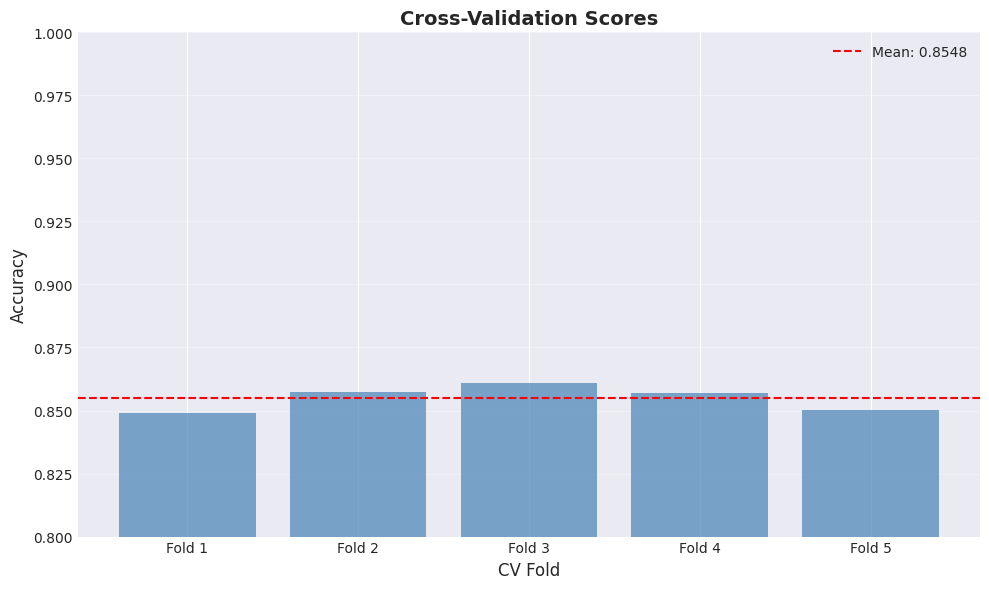

In [ ]:
print("Cross-Validation Results:")
print("=" * 70)
print(f"Mean CV Accuracy: {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std() * 2:.4f})")
print(f"Individual CV Scores: {gb_cv_scores}")

print("\n" + "=" * 70)
print("Train/Validation Split Results:")
print("=" * 70)
print(f"Training Accuracy: {gb_train_score:.4f}")
print(f"Validation Accuracy: {gb_val_score:.4f}")
print(f"Overfitting Gap: {gb_train_score - gb_val_score:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(gb_cv_scores)), gb_cv_scores, color='steelblue', alpha=0.7)
plt.axhline(y=gb_cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {gb_cv_scores.mean():.4f}')
plt.xlabel('CV Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.xticks(range(len(gb_cv_scores)), [f'Fold {i+1}' for i in range(len(gb_cv_scores))])
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

from sklearn.metrics import log_loss

gb_params = gb_optimized.get_params()
gb_incremental = GradientBoostingClassifier(**gb_params)
gb_incremental.fit(X_train_split, y_train_split)

train_losses = []
val_losses = []
n_estimators_list = []

for train_pred_proba, val_pred_proba, n_est in zip(
    gb_incremental.staged_predict_proba(X_train_split),
    gb_incremental.staged_predict_proba(X_val_split),
    range(1, gb_incremental.n_estimators + 1)
):
    train_loss = log_loss(y_train_split, train_pred_proba)
    val_loss = log_loss(y_val_split, val_pred_proba)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    n_estimators_list.append(n_est)

sample_indices = np.arange(0, len(n_estimators_list), 10)
n_estimators_plot = [n_estimators_list[i] for i in sample_indices]
train_losses_plot = [train_losses[i] for i in sample_indices]
val_losses_plot = [val_losses[i] for i in sample_indices]

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_plot, train_losses_plot, 'o-', label='Training Loss', linewidth=2, markersize=6)
plt.plot(n_estimators_plot, val_losses_plot, 's-', label='Validation Loss', linewidth=2, markersize=6)
plt.xlabel('Number of Estimators (Epochs)', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('Training vs Validation Loss over Number of Estimators', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 5.3 Model Adaptation Based on Performance Analysis

Looking at all of the above model fittings, training, and in general considering the form of our data (movie reviews), it makes sense to adapt the model in the following way: removing all stopwords. Stop words are words like "the" or "and" which may be considered by our model because they exist within the review, but do not hold any value towards classifying positive vs. negative.


In [ ]:
gb_gap = gb_train_score - gb_val_score

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
train_idx, val_idx = next(sss.split(X_train_vec_no_stop, y_train_binary))

X_train_split_no_stop = X_train_vec_no_stop[train_idx]
y_train_split = y_train_binary[train_idx]
X_val_split_no_stop = X_train_vec_no_stop[val_idx]
y_val_split = y_train_binary[val_idx]

gb_adapted1 = gb_optimized.__class__(**gb_optimized.get_params())
gb_adapted1.fit(X_train_split_no_stop, y_train_split)

train_acc_1 = gb_adapted1.score(X_train_split_no_stop, y_train_split)
val_acc_1 = gb_adapted1.score(X_val_split_no_stop, y_val_split)

gb_params = gb_optimized.get_params()
gb_params['learning_rate'] = max(0.01, gb_params.get('learning_rate', 0.1) * 0.7)
gb_params['min_samples_split'] = max(5, gb_params.get('min_samples_split', 2) * 2)

gb_adapted2 = gb_optimized.__class__(**gb_params)
gb_adapted2.fit(X_train_split_no_stop, y_train_split)

train_acc_2 = gb_adapted2.score(X_train_split_no_stop, y_train_split)
val_acc_2 = gb_adapted2.score(X_val_split_no_stop, y_val_split)

gb_adapted2.fit(X_train_vec_no_stop, y_train_binary)
test_acc_adapted = gb_adapted2.score(X_test_vec_no_stop, y_test_binary)

print(f"Original: Test={test_accuracy_gb_opt:.4f}, Gap={gb_gap:.4f}")
print(f"Adaptation 1 (no stop words): Train={train_acc_1:.4f}, Val={val_acc_1:.4f}, Gap={train_acc_1-val_acc_1:.4f}")
print(f"Adaptation 2 (+ regularization): Train={train_acc_2:.4f}, Val={val_acc_2:.4f}, Gap={train_acc_2-val_acc_2:.4f}, Test={test_acc_adapted:.4f}")


Original: Test=0.8555, Gap=0.1275
Adaptation 1 (no stop words): Train=0.9896, Val=0.8660, Gap=0.1236
Adaptation 2 (+ regularization): Train=0.9728, Val=0.8612, Gap=0.1116, Test=0.8620


Analysis on that...

---

## 6. Summary

### 6.1 Key Findings

### 6.2 Conclusions


### 6.3 Dataset Citation

```
@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
```
